# CLIP-DINOiser visualization demo 🖼️

In [37]:
from hydra.core.global_hydra import GlobalHydra
import os
from models.builder import build_model
from helpers.visualization import mask2rgb
from segmentation.datasets import PascalVOCDataset
from hydra import compose, initialize
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms as T
import torch.nn.functional as F
import numpy as np
from operator import itemgetter 
import torch
import warnings
warnings.filterwarnings('ignore')
GlobalHydra.instance().clear()
initialize(config_path="configs", version_base=None)


hydra.initialize()

In [38]:
def load_image(image_path):
    image = Image.open(image_path).convert('RGB')
    transform = T.Compose([
        T.Resize((224, 224)),
        T.ToTensor(),
        T.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))
    ])
    return transform(image).unsqueeze(0)

def load_support_images(support_image_paths):
    support_images = [load_image(image_path) for image_path in support_image_paths]
    return torch.cat(support_images, dim=0)

In [39]:
# Function to visualize per image
def visualize_per_image(file_path, support_image_paths, palette, model):
    assert os.path.isfile(file_path), f"No such file: {file_path}"

    # Load the input image
    img = Image.open(file_path).convert('RGB')
    img_tens = T.PILToTensor()(img).unsqueeze(0).to(device) / 255.

    # Load and process support images
    support_images = load_support_images(support_image_paths).to(device)

    # Generate embeddings for the support images
    with torch.no_grad():
        support_embeddings, _ = model.get_clip_features(support_images)

    # Update the model's decode head with the support embeddings
    model.clip_backbone.decode_head.update_vocab(support_embeddings)

    # Perform inference using the support embeddings
    h, w = img_tens.shape[-2:]
    output = model(img_tens).cpu()
    output = F.interpolate(output, scale_factor=model.vit_patch_size, mode="bilinear", align_corners=False)[..., :h, :w]
    output = output[0].argmax(dim=0)
    mask = mask2rgb(output, palette)

    # Visualize the results
    fig = plt.figure(figsize=(3, 1))
    classes = np.unique(output).tolist()
    plt.imshow(np.array(itemgetter(*classes)(palette)).reshape(1, -1, 3))
    plt.xticks(np.arange(len(classes)), [f"Class {i}" for i in classes], rotation=45)
    plt.yticks([])

    return mask, fig, img

### Load and configure a model

In [40]:
# Load the model checkpoint
check_path = './checkpoints/last.pt'
check = torch.load(check_path, map_location='cpu')

# Load the configuration
dinoclip_cfg = "clip_dinoiser.yaml"
cfg = compose(config_name=dinoclip_cfg)

# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Build the model
model = build_model(cfg.model, class_names=PascalVOCDataset.CLASSES).to(device)
model.clip_backbone.decode_head.use_templates = False  # Switching off the imagenet templates for fast inference

# Load the model state
model.load_state_dict(check['model_state_dict'], strict=False)
model = model.eval()

### Example with 'background' class

In [7]:
file = 'assets/vintage_bike.jpeg'
PALETTE = [(0, 0, 0), (156, 143, 189), (79, 158, 101)]

# specify your prompts
TEXT_PROMPTS = ['leather bag']
model.clip_backbone.decode_head.update_vocab(TEXT_PROMPTS)
model.to(device)

# set apply FOUND (background detector) to True
model.apply_found = True

# run segmentation
mask, ticks, img = visualize_per_image(file, TEXT_PROMPTS, PALETTE, model)

fig, ax = plt.subplots(nrows=1, ncols=2)
alpha=0.5
blend = (alpha)*np.array(img)/255. + (1-alpha) * mask/255.
ax[0].imshow(blend)
ax[1].imshow(mask)
ax[0].axis('off')
ax[1].axis('off')

FileNotFoundError: [Errno 2] No such file or directory: '/Users/micheleverriello/clip_dinoiser/leather bag'

### Example without 'background' class

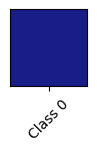

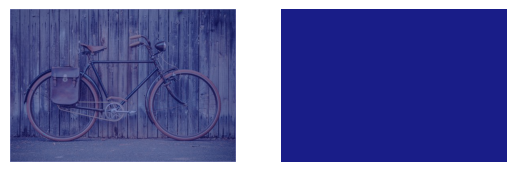

In [29]:
# Example usage
file = 'assets/vintage_bike.jpeg'
PALETTE = [[25, 29, 136], [128, 112, 112], [85, 124, 85], [250, 112, 112], [250, 250, 0], [250, 0, 0]]

# Add a cell to input the paths to support images
support_image_paths = [
    "assets/bike.jpeg"
]

# Load the support images
support_images = load_support_images(support_image_paths)

# Specify whether applying FOUND or not
model.apply_found = False

# Visualize per image
mask, ticks, img = visualize_per_image(file, support_image_paths, PALETTE, model)

# Display the results
fig, ax = plt.subplots(nrows=1, ncols=2)
alpha = 0.5
blend = (alpha) * np.array(img) / 255. + (1 - alpha) * mask / 255.
ax[0].imshow(blend)
ax[1].imshow(mask)
ax[0].axis('off')
ax[1].axis('off')
plt.show()